<a href="https://colab.research.google.com/github/RMoulla/Machine-learning/blob/main/TP_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Les machines à vecteurs de support
Dans ce TP, nous allons construire un modèle de machines à vecteurs de support linéaire pour une classification binaire, en considérant un jeu de données synthétiques.

Nous avons vu en cours que les SVM créent un hyperplan qui sépare efficacement les différentes classes de données. Dans le cas d'un SVM linéaire, en 2D dans notre cas, cet hyperplan est une ligne droite.

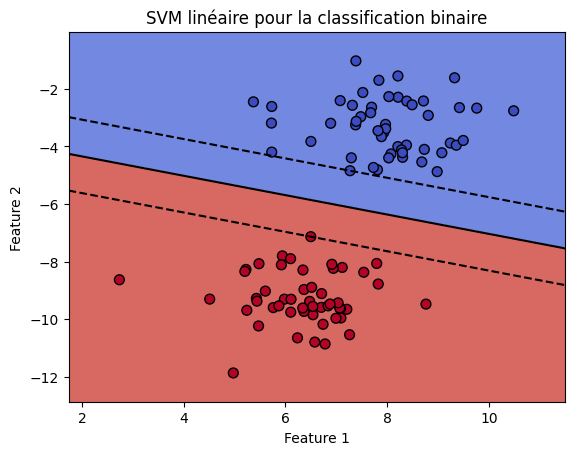

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs

# Création de données simulées : 2 groupes clairement séparables
X, y = make_blobs(n_samples=100, centers=2, random_state=6)

# Entraînement d'un modèle SVM
model = svm.SVC(kernel='linear', C=1.0)
model.fit(X, y)

# Créer une grille pour visualiser les régions de décision
xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 500),
                     np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 500))

# Prédiction pour chaque point de la grille
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Obtenir les coefficients pour la ligne de décision
w = model.coef_[0]
a = -w[0] / w[1]
xx_lin = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1)
yy_lin = a * xx_lin - (model.intercept_[0]) / w[1]

# Marges de l'hyperplan
margin = 1 / np.sqrt(np.sum(model.coef_ ** 2))
yy_down = yy_lin - np.sqrt(1 + a ** 2) * margin
yy_up = yy_lin + np.sqrt(1 + a ** 2) * margin

# Visualisation
plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm', edgecolors='k')
plt.plot(xx_lin, yy_lin, 'k-')
plt.plot(xx_lin, yy_down, 'k--')
plt.plot(xx_lin, yy_up, 'k--')
plt.title("SVM linéaire pour la classification binaire")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


## SVM linéaires

Dans le cas linéaire, l'hyperplan séparateur est défini dans l'espace des caractéristiques $\mathbf{x}$ par l'équation :

$$\mathbf{w}\cdot\mathbf{x} + b =0$$

où $\mathbf{w}$ est le vecteur normal à l'hyperplan séparateur et $b$ le biais.
Entraîner un modèle SVM revient alors à calculer ces deux inconnues. Pour ce faire, on considère le problème d'optimisation suivant :

* minimiser $\frac{1}{2}\lVert\mathbf{w}\rVert^2$ (ce qui revient à maximiser les marges)

sous la contrainte :
* $y_i(\mathbf{w}\cdot\mathbf{x}_i + b) \geq 1$ (classifier correctement les données d'entraînement).

Ce qui s'écrit sous la formulation duale de l'optimisation :      
* maximiser $W(\alpha) = \sum_{i=1}^{n} \alpha_i - \frac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{n} y_i y_j \alpha_i \alpha_j \langle \mathbf{x}_i, \mathbf{x}_j \rangle$

sous les contraines :     
* $\sum_{i=1}^{n} \alpha_i y_i = 0 \text{ et } 0 \leq \alpha_i \leq C$ pour chaque $i$.

où les $\alpha_i$ sont les multiplicateurs de Lagrange. Leur calcul nous permet d'obtenir les vecteurs de support qui définissent les marges de l'hyperplan séparateur.
Plus concrètement, ce problème d'optimisation sera résolu à l'aide d'un solveur fourni par le package Python `cvxopt`.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.datasets import make_blobs

In [ ]:
# Génération de données synthétiques
X, y = make_blobs(n_samples=300, centers=2, random_state=0, cluster_std=1)
y = np.where(y == 0, -1, 1)

# Partitionnement en dataset de train et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=111)

# Normalisation des données, indispensable pour avant d'entraîner un SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

For dataset 1, score: 1.0


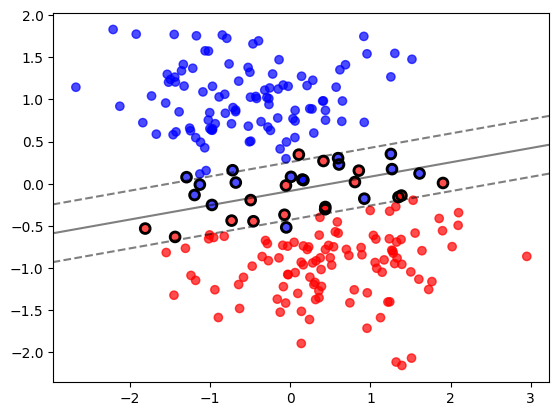

In [ ]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def fit_svm(X, y, C=1.0):
    n_samples, n_features = X.shape
    y = y.astype(float)

    # Matrice de Gram (produit scalaire entre chaque paire de points)
    K = np.dot(X, X.T)

    # Convertir en format cvxopt
    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones(n_samples))
    G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
    h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)))
    A = matrix(y, (1, n_samples), 'd')
    b = matrix(0.0)

    # Résoudre le problème d'optimisation quadratique
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)

    # Extraire les multiplicateurs de Lagrange
    alphas = np.ravel(solution['x'])

    # Les vecteurs de support ont des alphas non nuls
    sv = alphas > 1e-5
    ind = np.arange(len(alphas))[sv]
    alphas = alphas[sv]
    sv_X = X[sv]
    sv_y = y[sv]

    # Calculer les paramètres du modèle
    w = np.sum(sv_X.T * alphas * sv_y, axis=1)
    b = np.mean(sv_y - np.dot(sv_X, w))

    return w, b, sv_X, sv_y

def predict_svm(X, w, b):
    return np.sign(np.dot(X, w) + b)

def plot_svm(X, y, w, b, sv_X, sv_y):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)

    # Ligne de décision
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    xy = np.vstack([xx.ravel(), yy.ravel()]).T
    P = np.dot(xy, w) + b
    P = P.reshape(xx.shape)
    ax.contour(xx, yy, P, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Vecteurs de support
    ax.scatter(sv_X[:, 0], sv_X[:, 1], s=50, facecolors='none', edgecolors='k', linewidths=2)

    plt.show()


# Entraîner le SVM
w, b, sv_X, sv_y = fit_svm(X_train_scaled, y_train, C=1.0)

y_pred = predict_svm(X_test_scaled, w, b)

print("Accuracy :" ,accuracy_score(y_pred,y_test))


plot_svm(X_train_scaled, y_train, w, b, sv_X, sv_y)

## SVM à noyaux

Dans le cas où les données ne sont pas séparables linéaires, on peut utiliser des noyaux vérifiant certaines conditions (théorème de Mercer) qui permettent de transformer les données vers un espace de plus grande dimension. Celles-ci peuvent ensuite être séparées linéairement dans ce nouvel espace.

Nous allons considérer ici un noyau RBF (Radial Basis Function), défini par :     
* $K(\mathbf{x}_i, \mathbf{x}_j) = \exp(-\gamma \|\mathbf{x}_i - \mathbf{x}_j\|^2)$

La formulation duale du problème d'optimisation s'écrit pour les SVM à noyaux :    

* $W(\alpha) = \sum_{i=1}^{n} \alpha_i - \frac{1}{2} \sum_{i,j=1}^{n} y_i y_j \alpha_i \alpha_j K(\mathbf{x}_i, \mathbf{x}_j)$

avec les contraintes :    
* $\sum_{i=1}^{n} \alpha_i y_i = 0 \quad \text{et} \quad 0 \leq \alpha_i \leq C$ pour chaque $i$.

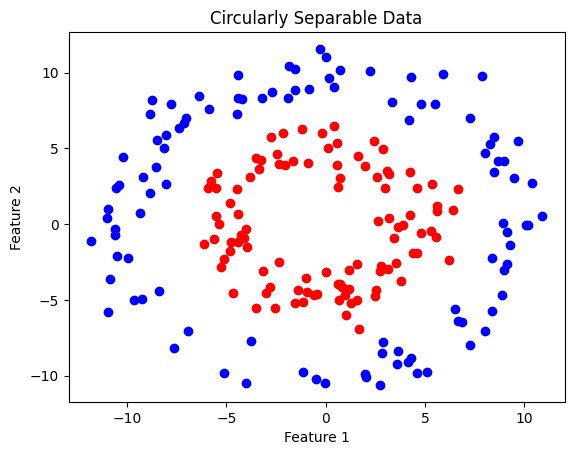

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_circular_data(radius=5, num_samples=100, noise=0.5):
    """
    Génère des données circulaires.
    :param radius: Rayon du cercle.
    :param num_samples: Nombre d'échantillons à générer.
    :param noise: Variabilité des données autour du cercle.
    :return: Un array NumPy des données générées.
    """
    angles = np.random.rand(num_samples) * 2 * np.pi
    radii = radius + noise * np.random.randn(num_samples)
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    return np.column_stack((x, y))

# Générer des données pour deux classes
data_class_1 = generate_circular_data(radius=5, num_samples=100, noise=1.0)
data_class_2 = generate_circular_data(radius=10, num_samples=100, noise=1.0)

# Visualisation des données
plt.scatter(data_class_1[:, 0], data_class_1[:, 1], color='red')
plt.scatter(data_class_2[:, 0], data_class_2[:, 1], color='blue')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Circularly Separable Data')
plt.show()



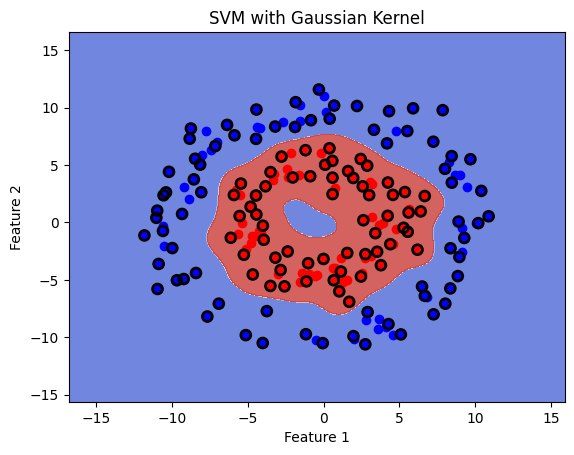

In [ ]:
from cvxopt import matrix, solvers

def gaussian_kernel(x1, x2, sigma=1.0):
    return np.exp(-np.linalg.norm(x1 - x2) ** 2 / (2 * (sigma ** 2)))

def fit_svm_rbf(X, y, C=1, sigma=1.0):
    n_samples, n_features = X.shape
    y = y.astype(float)

    # Matrice du noyau
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = gaussian_kernel(X[i], X[j], sigma)

    # Convertir en format cvxopt
    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones(n_samples))
    G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
    h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)))
    A = matrix(y, (1, n_samples), 'd')
    b = matrix(0.0)

    # Résoudre le problème d'optimisation quadratique
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)

    # Extraire les multiplicateurs de Lagrange
    alphas = np.ravel(solution['x'])

    # Support vectors ont des alphas non nuls
    sv = alphas > 1e-5
    alphas = alphas[sv]
    sv_X = X[sv]
    sv_y = y[sv]

    # Calculer le biais
    b = np.mean([y_k - np.sum(alphas * sv_y * np.array([gaussian_kernel(x_k, x_i, sigma) for x_i in sv_X])) for x_k, y_k in zip(sv_X, sv_y)])

    return alphas, sv_X, sv_y, b

# Préparation des données
X = np.vstack((data_class_1, data_class_2))
y = np.hstack((np.ones(data_class_1.shape[0]), -np.ones(data_class_2.shape[0])))

# Entraînement du SVM
alphas, sv_X, sv_y, b = fit_svm_rbf(X, y, C=1.0, sigma=1.0)


def predict_svm_rbf(X, alphas, sv_X, sv_y, b, sigma=1.0):
    y_pred = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        y_pred[i] = np.sum(alphas * sv_y * np.array([gaussian_kernel(X[i], sv, sigma) for sv in sv_X])) + b
    return np.sign(y_pred)

# Créer une grille pour visualiser la région de décision
xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 5, X[:, 0].max() + 5, 500),
                     np.linspace(X[:, 1].min() - 5, X[:, 1].max() + 5, 500))

# Prédire pour chaque point de la grille
Z = predict_svm_rbf(np.c_[xx.ravel(), yy.ravel()], alphas, sv_X, sv_y, b, sigma=1.0)
Z = Z.reshape(xx.shape)

# Visualisation
plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
plt.scatter(data_class_1[:, 0], data_class_1[:, 1], color='red')
plt.scatter(data_class_2[:, 0], data_class_2[:, 1], color='blue')
plt.scatter(sv_X[:, 0], sv_X[:, 1], s=50, facecolors='none', edgecolors='k', linewidths=2) # Vecteurs de support
plt.title("SVM with Gaussian Kernel")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

